  0.083811 seconds (1.12 M allocations: 48.238 MiB, 23.20% gc time)
  8.571700 seconds (7.18 M allocations: 290.402 MiB, 0.73% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\karol\Desktop\programowanie\animacja1.gif
└ @ Plots C:\Users\karol\.julia\packages\Plots\kyYZF\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\karol\\Desktop\\programowanie\\animacja1.gif")
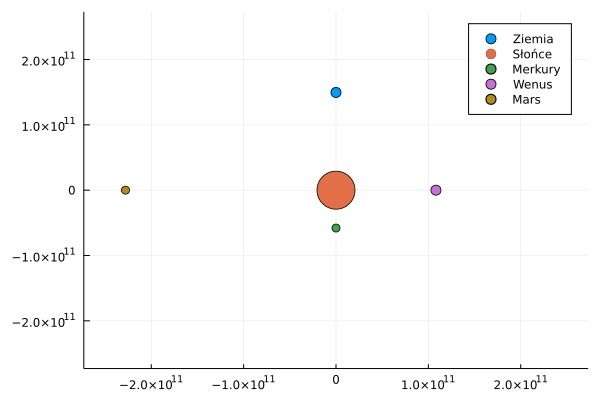

In [10]:
using Base: Float64
# Głowny program do wyliczania i wyśweitlania położenia ciał 

# Pakiety
using Plots, LinearAlgebra, Statistics, Parameters, AstroLib

# Ważne stałe
Q = 14                    # pozwala używać Float64 zamiast BigFloat
G = 6.6732*10^(-11+2Q)     # stała grawitacji 
def_size = 8.0              # domyślna wielkość wyświetlana na animacji
MS = 1.989*10^(30-Q)    #masa slonca
RS = 695000000.0 #promień slonca
Number_of_planets = 4
# Typ planeta
@with_kw mutable struct My_planet
    name::String
    mass::Float64
    coord::Array{Float64,1}
    v_vec::Array{Float64,1}
    a_vec::Array{Float64,1} = [0, 0]
    size::Float64 = 6.0
    coords_list::Array{Array{Float64,1},1} = []
    v_vecs_list::Array{Float64,1} = []
    a_vecs_list::Array{Float64,1} = []
    every_frame_time::Int64 = 0
end

# Układ słoneczny ze Słońcem w centrum
Ziemia = My_planet(name = "Ziemia", mass = AstroLib.planets["earth"].mass * 10.0^(-Q), coord = [0, AstroLib.planets["earth"].axis], v_vec = [29.78*10^3, 0])
Słońce = My_planet(name = "Słońce", mass = 1.989*10^(30-Q), coord = [0, 0], v_vec = [0, 0])
Merkury = My_planet(name = "Merkury", mass = AstroLib.planets["mercury"].mass* 10.0^(-Q), coord = [0, -58*10^9], v_vec = [-48*10^3, 0])
Wenus = My_planet(name = "Wenus", mass = AstroLib.planets["venus"].mass* 10.0^(-Q), coord = [AstroLib.planets["venus"].axis, 0], v_vec = [0, -35.02*10^3])
Mars = My_planet(name = "Mars", mass = AstroLib.planets["mars"].mass* 10.0^(-Q), coord = [-AstroLib.planets["mars"].axis, 0], v_vec = [0, 24.07*10^3])


Jowisz = My_planet(name = "Jowisz", mass = AstroLib.planets["jupiter"].mass* 10.0^(-Q), coord = [AstroLib.planets["jupiter"].axis, 0], v_vec = [0, -13*10^3])
Saturn = My_planet(name = "Saturn", mass = AstroLib.planets["saturn"].mass* 10.0^(-Q), coord = [-AstroLib.planets["saturn"].axis, 0], v_vec = [0, 9.6*10^3])
Uran = My_planet(name = "Uran", mass = AstroLib.planets["uranus"].mass* 10.0^(-Q), coord = [-AstroLib.planets["uranus"].axis, 0], v_vec = [0, 6.8*10^3])
Neptun = My_planet(name = "Neptun", mass = AstroLib.planets["neptune"].mass* 10.0^(-Q), coord = [-AstroLib.planets["neptune"].axis, 0], v_vec = [0, 5.4*10^3])

lista_solar = [Ziemia, Słońce, Merkury, Wenus, Mars]
if Number_of_planets == 8
    push!(lista_solar, Jowisz,Saturn, Uran, Neptun)
end
    
#---------------------------------------------------------------------------------------------
#       FUNKCJE DO OBLICZEŃ 
#---------------------------------------------------------------------------------------------

dist_vec(coord1::Array{Float64,1},coord2::Array{Float64,1}) = coord2 .- coord1
"""Wylicza wektor odległości z coord1 do coord2"""

F_gravity(M1::Float64,M2::Float64,r::Array) = (G/norm(r))*(M1/norm(r))*(M2/norm(r)).*r
"""Wylicza wektor siły grawitacji"""

function the_farthest(lista::Array{My_planet,1})
"""Podaj odległość najdalszej planety od środka układu"""
    return maximum(norm(x.coord) for x in lista) 
end

function Scale_size(planeta::My_planet, rel_mass::Float64, def_size = 6)
"""Zwróć przeskalowany rozmiar planety do wyświetlania"""
    return (planeta.mass/rel_mass)^(0.1)*def_size
end

function Scale_planets(lista::Array{My_planet,1})
"""Skaluj planety względem mediany"""
    mass_list = collect(m.mass for m in lista)
    rel_mass = median(mass_list)
    for i in lista
        i.size = Scale_size(i,rel_mass)
    end
    
        
end

function MainFunction(lista::Array{My_planet,1},T::Int64)
"""Zmień położenie planety o podaną jednostkę czasu
===================================================
lista - listę obiektów typu My_planet
T - czas w sekundach po jakim przeliczy nową pozycję"""

    for i in eachindex(lista)
        FG=[0.0, 0.0]
        for j in eachindex(lista)
            if j != i
                r = dist_vec(lista[i].coord, lista[j].coord)
                F = F_gravity(lista[i].mass, lista[j].mass, r)
                FG += F
            end
        end
        lista[i].a_vec = FG./lista[i].mass.*(0.1^Q)      # ustawia wektor przyspieszenia planety 
    end
    for i in eachindex(lista)
        lista[i].v_vec += T.*lista[i].a_vec
        lista[i].coord += T.*lista[i].v_vec  
    end
end

function Set_coord_list(planets_list::Array{My_planet,1}, frames::Int64, delta_time::Int64, conversion_number::Int64)
"""Zapisuje położenia planety w ich atrybucie coords_list
===========================================================
frames - zapisywana ilość klatek( położeń planety)
delta_time - czas w sekundach po jakim przeliczy nową pozycję
conversion_number - ilość przeliczeń na każdą zapisaną klatkę"""

    for i in 1:frames
        for i in planets_list
            push!(i.coords_list, i.coord)
        end
        for i in 1:conversion_number
            MainFunction(planets_list,delta_time)
        end   
    end
end

function make_symulation1(planets_list::Array{My_planet,1})
"""Tworzy animację ruchu planet na podstawie zapisanych pozycji w atrybucie coords_list"""

    Scale_planets(planets_list)
    dist_limit = the_farthest(planets_list)*1.2
    symulation = @animate for i in 1:length(planets_list[1].coords_list)
        scatter([planets_list[1].coords_list[i][1]],[planets_list[1].coords_list[i][2]],
        xlim = (-dist_limit, dist_limit),
        ylim = (-dist_limit, dist_limit), 
        markersize = planets_list[1].size,
        label = planets_list[1].name)

        for j in 2:length(planets_list)
            scatter!([planets_list[j].coords_list[i][1]],[planets_list[j].coords_list[i][2]],
            markersize = planets_list[j].size,
            label = planets_list[j].name)
        end 
    end
    return symulation
end


#-------------------------------------------------------------------------------------------
#               SYMULACJA
#-------------------------------------------------------------------------------------------

# PARAMETRY
frames = 200
delta_time = 2000
conversion_number = 20
fps = 40

dist_limit = the_farthest(lista_solar)*1.2
Scale_planets(lista_solar)
if Number_of_planets == 8
        lista_solar[2].size = lista_solar[2].size * 10^-20
end
@time Set_coord_list(lista_solar,frames,delta_time,conversion_number)
@time symulation1 = make_symulation1(lista_solar)
gif(symulation1,"animacja1.gif", fps=fps)

#=
symulation1 = @animate for i in 1:frames
    scatter([lista_solar[1].coords_list[i][1]],[lista_solar[1].coords_list[i][2]],
    xlim = (-dist_limit, dist_limit),
    ylim = (-dist_limit, dist_limit), 
    markersize = lista_solar[1].size)
    for j in 2:length(lista_solar)
        scatter!([lista_solar[j].coords_list[i][1]],[lista_solar[j].coords_list[i][2]],
        markersize = lista_solar[j].size)
    end
end
=#



#@time symulation2 = make_symulation2(lista_solar)
#gif(symulation2,"animacja2.gif", fps=fps)


#=
@time symulation = @animate for i in 1:t
    scatter([lista_solar[1].coord[1]], [lista_solar[1].coord[2]],
    xlim = (-dist_limit, dist_limit),
    ylim = (-dist_limit, dist_limit), 
    markersize = lista_solar[1].size)
    for i in 2:length(lista_solar)
        scatter!([lista_solar[i].coord[1]], [lista_solar[i].coord[2]],
        markersize = lista_solar[i].size)
    end
    for i in 1:n
        MainFunction(lista_solar,T)
    end
end
gif(symulation,"animacja.gif", fps=fps)
=#
